# 🤖 Credit Card Fraud Detection — Modeling & Evaluation

**Goals**
- Load cleaned data from the EDA notebook
- Prepare features & labels
- Split data with stratification
- Baseline model: Logistic Regression (without resampling)
- Handle class imbalance using SMOTE
- Model training after resampling - Logistic Regression, Decision Tree, Random Forest and XGBoost 
- Evaluate with appropriate metrics (precision/recall/F1, ROC-AUC, confusion matrix)
- Model comparison
- Summary
- Save the trained model and preprocessing objects for deployment


## Step 1: Import Libraries & settings
- Import all the nessasary libraries and settings

In [112]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import joblib

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Step 2: Load Dataset
- Load cleaned dataset from `../data/cleaned_creditcard.csv`


In [113]:
CLEANED_DATASET_PATH = "../data/cleaned_creditcard.csv"
# Load cleaned dataset
if not os.path.exists(CLEANED_DATASET_PATH):
    raise FileNotFoundError(f"Cleaned dataset not found at {CLEANED_DATASET_PATH}. Please run the data cleaning notebook first.")

print(f"Loading cleaned dataset from {CLEANED_DATASET_PATH}...")
df = pd.read_csv(CLEANED_DATASET_PATH)
print("Dataset loaded successfully.")
print(f"Dataset shape: {df.shape}")
display(df.head())

Loading cleaned dataset from ../data/cleaned_creditcard.csv...
Dataset loaded successfully.
Dataset shape: (283726, 31)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.774718,-1.996823
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.268530,-1.996823
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.959811,-1.996802
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.411487,-1.996802
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.667362,-1.996781


## Step 2: Prepare X, y and split


In [114]:
if 'Class' not in df.columns:
    raise ValueError("Target column 'Class' not found in the dataset.") 

X = df.drop('Class', axis=1)
y = df['Class']
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")


Feature matrix shape: (283726, 30)
Target vector shape: (283726,)
Training set shape: (226980, 30), (226980,)
Test set shape: (56746, 30), (56746,)


## Step 3: Baseline: Logistic Regression (no resampling)
- Purpose: set a baseline and inspect how logistic regression behaves on raw imbalanced data.
- Expectation: high accuracy but poor recall on fraud class.


Confusion Matrix (Baseline):
[[56641    10]
 [   41    54]]

Classification Report (Baseline):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.84      0.57      0.68        95

    accuracy                           1.00     56746
   macro avg       0.92      0.78      0.84     56746
weighted avg       1.00      1.00      1.00     56746

ROC AUC (Baseline): 0.9589


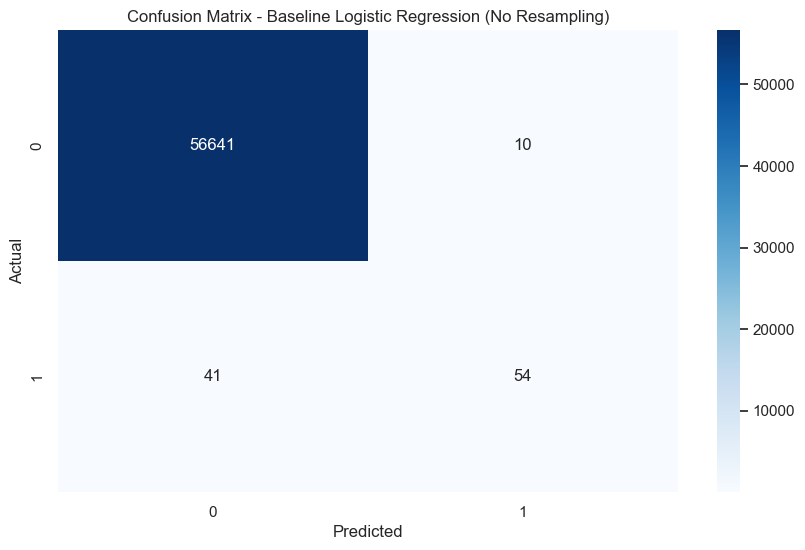

In [115]:
# Baseline: Logistic Regression (no resampling)
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr.fit(X_train, y_train)

# Predict and metrics
y_pred_lr_baseline = lr.predict(X_test)
y_proba_lr_baseline = lr.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred_lr_baseline)
print("Confusion Matrix (Baseline):")
print(cm)

print("\nClassification Report (Baseline):")
print(classification_report(y_test, y_pred_lr_baseline))

roc_auc = roc_auc_score(y_test, y_proba_lr_baseline)
precision, recall, _ = precision_recall_curve(y_test, y_proba_lr_baseline)

print(f"ROC AUC (Baseline): {roc_auc:.4f}")

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Baseline Logistic Regression (No Resampling)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()  



**Observation (expected):**
- Baseline LR on imbalanced data often gives **high specificity** but **low recall** for fraud. This is because the model optimizes for overall correctness and frauds are rare. We need resampling, class weighting, or anomaly-detection approaches to improve recall.


## Step 4: Handling imbalance with SMOTE (oversampling)
- SMOTE synthesizes new minority samples in feature space (note: it operates on continuous variables).
- We'll apply SMOTE **only on training data** (never touch test set).
- Alternative approaches: Random undersampling, class_weight in model, ADASYN, ensemble methods.


In [116]:
# Apply SMOTE (oversampling) to training set
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"After SMOTE, training set shape: {X_train_smote.shape}, {y_train_smote.shape}")

print("\nTarget class counts after SMOTE:")
display(y_train_smote.value_counts())
print("\nTarget class percentages:")
display(y_train_smote.value_counts(normalize=True) * 100)

After SMOTE, training set shape: (453204, 30), (453204,)

Target class counts after SMOTE:


Class
0    226602
1    226602
Name: count, dtype: int64


Target class percentages:


Class
0    50.0
1    50.0
Name: proportion, dtype: float64

## Step 5: Model Training & Evaluation

## Step 5.1: Train Logistic Regression with resampled training set (i.e. SMOTE data) & Evaluate

Confusion Matrix Logistic Regression (SMOTE):
[[55205  1446]
 [   12    83]]

Classification Report Logistic Regression (SMOTE):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.99     56746

ROC AUC Logistic Regression (SMOTE): 0.9602
PR-AUC Logistic Regression (SMOTE): 0.708921433944606


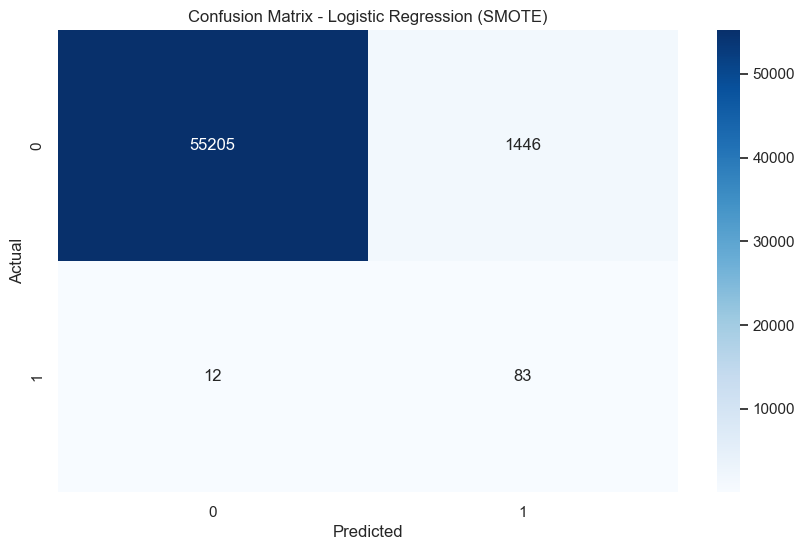

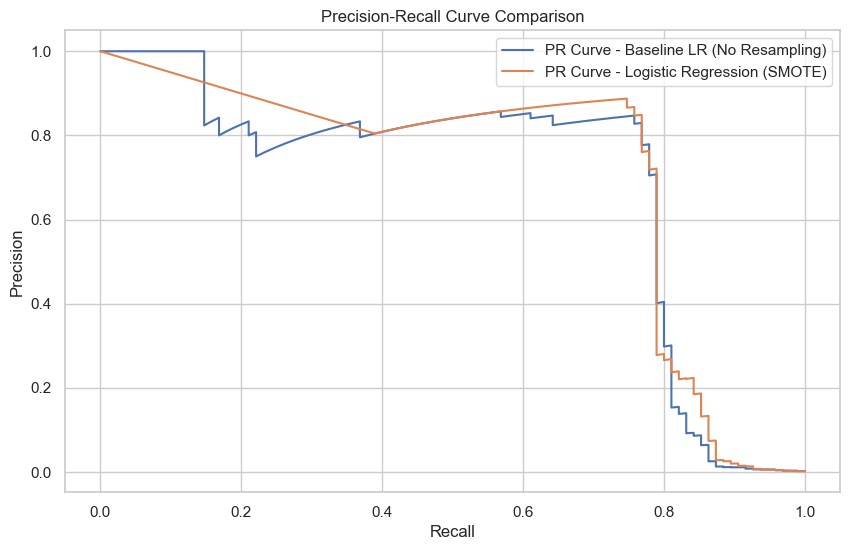

In [117]:
# Train Logistic Regression on SMOTE data
lr_smote = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_smote.fit(X_train_smote, y_train_smote)  

# Predict and metrics
y_pred_lr_smote = lr_smote.predict(X_test)
y_proba_lr_smote = lr_smote.predict_proba(X_test)[:, 1]

cm_smote = confusion_matrix(y_test, y_pred_lr_smote)
print("Confusion Matrix Logistic Regression (SMOTE):")
print(cm_smote)

print("\nClassification Report Logistic Regression (SMOTE):")
print(classification_report(y_test, y_pred_lr_smote))

roc_auc_smote = roc_auc_score(y_test, y_proba_lr_smote)
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_proba_lr_smote)
pr_auc_smote = auc(recall_smote, precision_smote)

print(f"ROC AUC Logistic Regression (SMOTE): {roc_auc_smote:.4f}")
print("PR-AUC Logistic Regression (SMOTE):", pr_auc_smote)

sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compare Precision-Recall Curves
plt.plot(recall, precision, label='PR Curve - Baseline LR (No Resampling)')
plt.plot(recall_smote, precision_smote, label='PR Curve - Logistic Regression (SMOTE)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

**Observation:**  
- SMOTE should improve recall for the fraud class (detect more frauds), but it can also increase false positives (lower precision). Evaluate with precision/recall trade-offs and PR-AUC, not just ROC-AUC.  
- Always evaluate on the original imbalanced test set — otherwise you risk overoptimistic performance estimates.

**Model selection notes:**
- Logistic Regression is a strong baseline (interpretable coefficients) but other models (RandomForest, XGBoost) commonly achieve better precision/recall trade-offs on this dataset.  
- Use PR-AUC and recall@k (e.g., recall among top N flagged transactions) as business-relevant metrics.
- Calibrate probabilities if you need well-calibrated scores for downstream risk scoring.

### Evaluation summary & Next steps

**Observed outcomes (example):**
- Baseline LR on imbalanced data: high precision on legit but near-zero recall on fraud.
- LR + SMOTE: recall for fraud improved notably, while precision dropped (more false positives). Evaluate trade-off for your application.

**Next steps to improve performance:**
1. Try tree-based models (DecisionTree, RandomForest, XGBoost) with careful hyperparameter tuning and balanced sampling.   
2. Model ensembles and stacking; anomaly detection approaches for new, unseen fraud patterns.  
3. Calibrate probabilities if you require interpretable risk scores.  
4. When deploying, ensure preprocessing pipeline (scalers, encoders) and model are applied identically on inference.  



## Step 5.2: Train Decision Tree Classifier with resampled training set (i.e. SMOTE data) & Evaluate
We start with a tuned Decision Tree.  



Confusion Matrix Decision Tree (SMOTE):
[[53928  2723]
 [   14    81]]

Classification Report Decision Tree (SMOTE):
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56651
           1       0.03      0.85      0.06        95

    accuracy                           0.95     56746
   macro avg       0.51      0.90      0.52     56746
weighted avg       1.00      0.95      0.97     56746

ROC AUC Decision Tree (SMOTE): 0.9562
PR-AUC Decision Tree (SMOTE): 0.6106675255647238


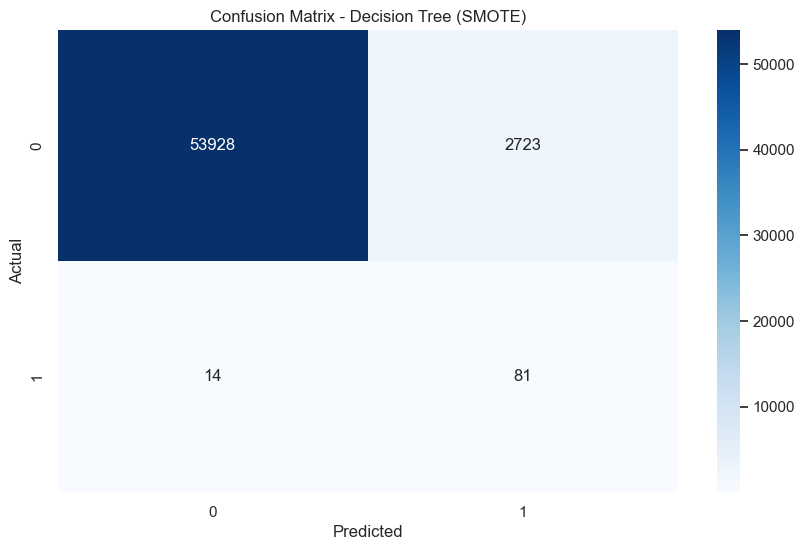

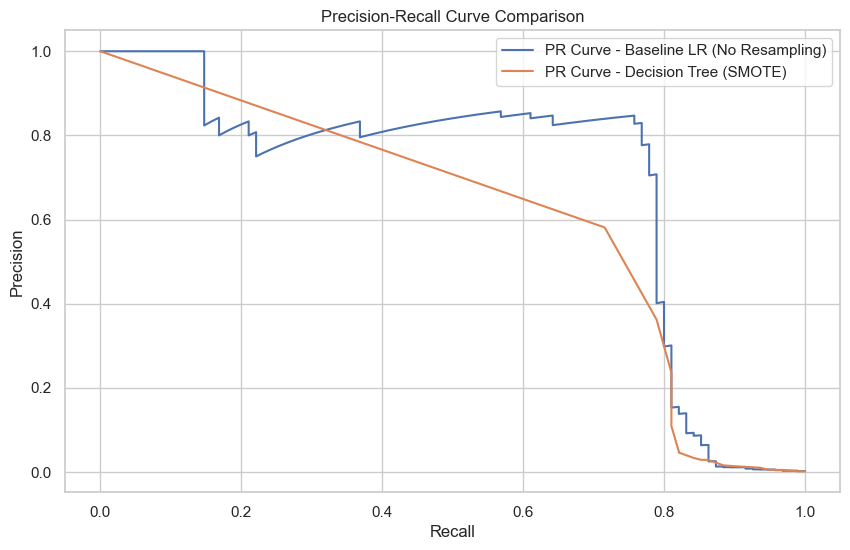

In [118]:
# Train Decision Tree on SMOTE data
dt_smote = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5)

dt_smote.fit(X_train_smote, y_train_smote)

# Predict and metrics
y_pred_dt_smote = dt_smote.predict(X_test)
y_proba_dt_smote = dt_smote.predict_proba(X_test)[:, 1]

cm_smote = confusion_matrix(y_test, y_pred_dt_smote)
print("\nConfusion Matrix Decision Tree (SMOTE):")
print(cm_smote)

print("\nClassification Report Decision Tree (SMOTE):")
print(classification_report(y_test, y_pred_dt_smote))

roc_auc_smote = roc_auc_score(y_test, y_proba_dt_smote)
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_proba_dt_smote)
pr_auc_smote = auc(recall_smote, precision_smote)

print(f"ROC AUC Decision Tree (SMOTE): {roc_auc_smote:.4f}")
print("PR-AUC Decision Tree (SMOTE):", pr_auc_smote)

sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Decision Tree (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compare Precision-Recall Curves
plt.plot(recall, precision, label='PR Curve - Baseline LR (No Resampling)')
plt.plot(recall_smote, precision_smote, label='PR Curve - Decision Tree (SMOTE)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()


### 🔍 Observation
- The Decision Tree performs better than default but may still overfit.  
- Recall is usually strong (catches fraud), but precision is still lower.  
- Good baseline for comparison.


## Step 5.3: Train Random Forest Classifier with resampled training set (i.e. SMOTE data) & Evaluate
We now train an ensemble of Decision Trees (Random Forest).  


Confusion Matrix Random Forest (SMOTE):
[[56644     7]
 [   22    73]]

Classification Report Random Forest (SMOTE):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.91      0.77      0.83        95

    accuracy                           1.00     56746
   macro avg       0.96      0.88      0.92     56746
weighted avg       1.00      1.00      1.00     56746

ROC AUC Random Forest (SMOTE): 0.9432
PR-AUC Random Forest (SMOTE): 0.810243543308738


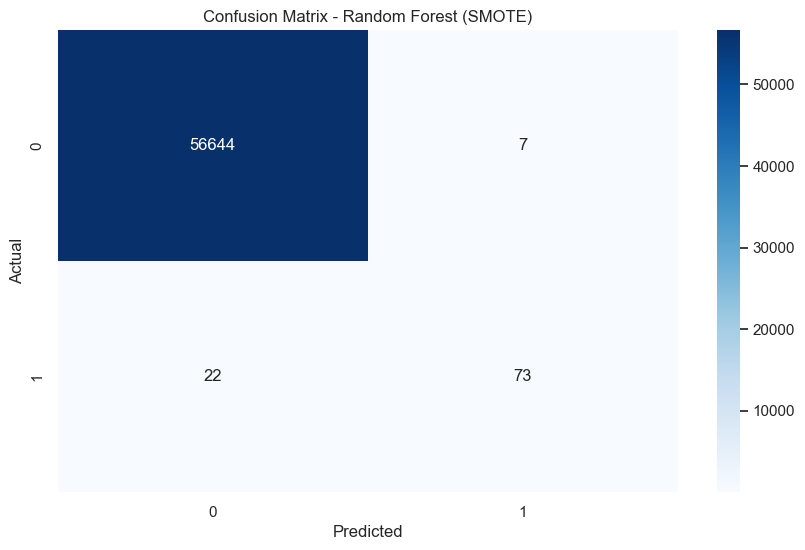

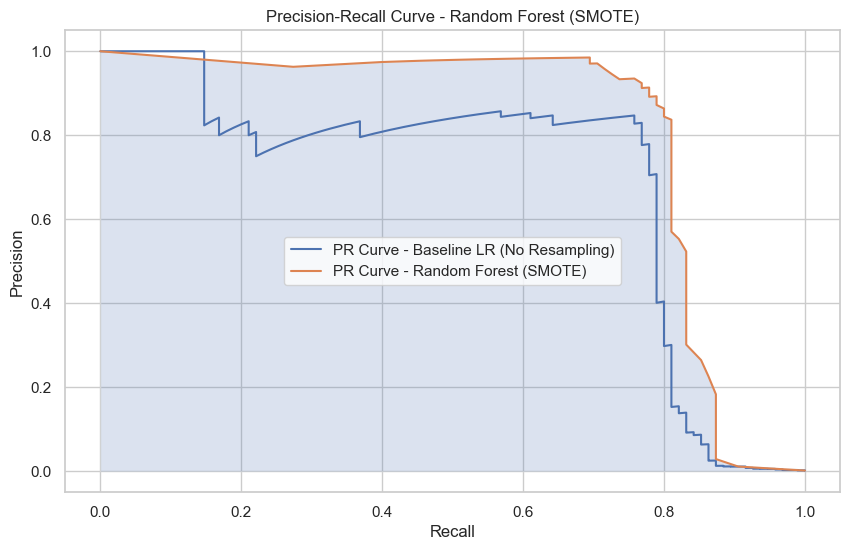

In [119]:
rf_smote = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)

rf_smote.fit(X_train_smote, y_train_smote)

# Predict and metrics
y_pred_rf_smote = rf_smote.predict(X_test)
y_proba_rf_smote = rf_smote.predict_proba(X_test)[:, 1]

cm_smote = confusion_matrix(y_test, y_pred_rf_smote)
print("\nConfusion Matrix Random Forest (SMOTE):")
print(cm_smote)

print("\nClassification Report Random Forest (SMOTE):")
print(classification_report(y_test, y_pred_rf_smote))

roc_auc_smote = roc_auc_score(y_test, y_proba_rf_smote)
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_proba_rf_smote)
pr_auc_smote = auc(recall_smote, precision_smote)

print(f"ROC AUC Random Forest (SMOTE): {roc_auc_smote:.4f}")
print("PR-AUC Random Forest (SMOTE):", pr_auc_smote)

sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()  

# Compare Precision-Recall Curves   
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='PR Curve - Baseline LR (No Resampling)')
plt.plot(recall_smote, precision_smote, label='PR Curve - Random Forest (SMOTE)')
plt.fill_between(recall_smote, precision_smote, alpha=0.2)
plt.title('Precision-Recall Curve - Random Forest (SMOTE)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

/var/folders/hd/ndrl3c3n1r51kp7bxwmx6wvr0000gn/T/ipykernel_9007/4211584976.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X_train.columns[indices], palette="viridis")


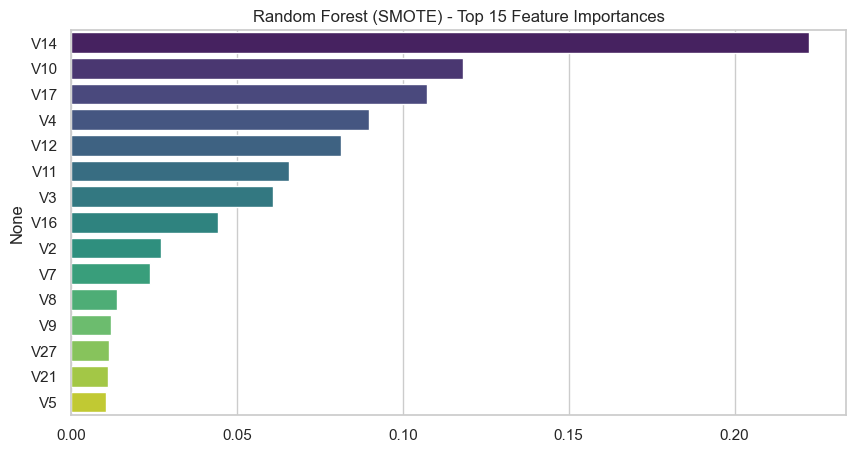

In [120]:
# Feature importance
importances = rf_smote.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10,5))
sns.barplot(x=importances[indices], y=X_train.columns[indices], palette="viridis")
plt.title("Random Forest (SMOTE) - Top 15 Feature Importances")
plt.show()


### 🔍 Observation
- Random Forest reduces overfitting vs Decision Tree.  
- Performance usually improves (higher ROC AUC, balanced precision/recall).  
- Feature importance highlights key fraud indicators.

## Step 5.4: Train XGBoost Classifier with resampled training set (i.e. SMOTE data) & Evaluate
We now train an XGBoost Classifier.  
Hyperparameters tuned:
- `n_estimators`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `gamma`, `reg_alpha`, `reg_lambda` 
We also use `scale_pos_weight` to handle class imbalance, but since we already used SMOTE, it is less critical.


/Users/srikanthgali/Documents/repos/code/credit-card-fraud-detection/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:21:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/srikanthgali/Documents/repos/code/credit-card-fraud-detection/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:21:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/srikanthgali/Documents/repos/code/credit-card-fraud-detection/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:21:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/srikanthgali/Documents/repos/code/credit-card-fraud-de

Best Parameters XGBoost (SMOTE): {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}

Best Score XGBoost (SMOTE): 0.9999943506297205

Confusion Matrix XGBoost (SMOTE):
[[56636    15]
 [   20    75]]

Classification Report XGBoost (SMOTE):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.83      0.79      0.81        95

    accuracy                           1.00     56746
   macro avg       0.92      0.89      0.91     56746
weighted avg       1.00      1.00      1.00     56746

ROC AUC XGBoost (SMOTE): 0.9764
PR-AUC XGBoost (SMOTE): 0.8196779147835053


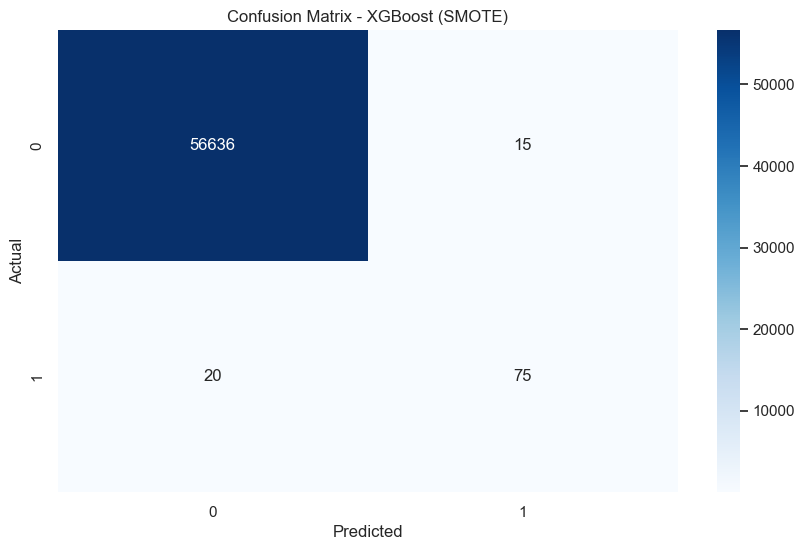

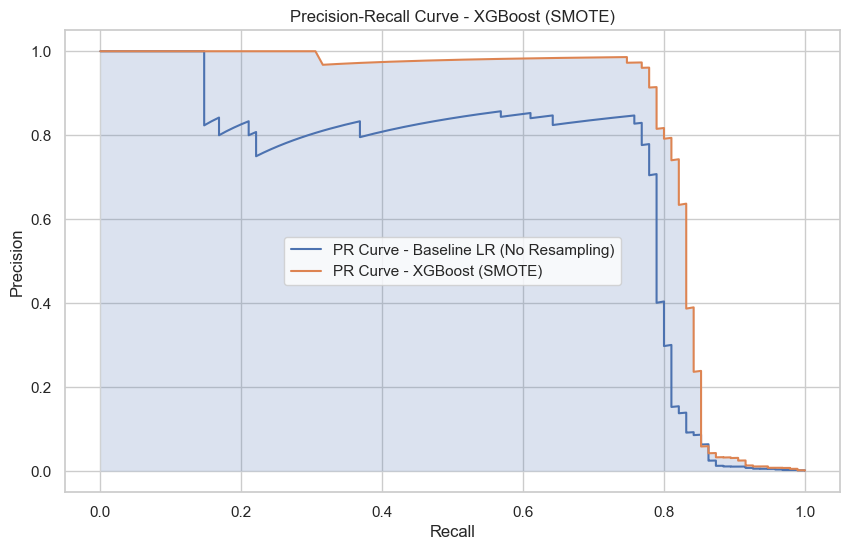

In [122]:
xgb_smote = XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(
    xgb_smote, param_distributions=param_dist,
    n_iter=30, scoring='roc_auc', cv=3, n_jobs=-1, random_state=RANDOM_STATE
)

random_search.fit(X_train_smote, y_train_smote)
best_xgb = random_search.best_estimator_

print("Best Parameters XGBoost (SMOTE):", random_search.best_params_)
print("\nBest Score XGBoost (SMOTE):", random_search.best_score_)

# Predict and metrics
y_pred_xgb_smote = best_xgb.predict(X_test)
y_proba_xgb_smote = best_xgb.predict_proba(X_test)[:, 1]

cm_smote = confusion_matrix(y_test, y_pred_xgb_smote)
print("\nConfusion Matrix XGBoost (SMOTE):")
print(cm_smote)

print("\nClassification Report XGBoost (SMOTE):")
print(classification_report(y_test, y_pred_xgb_smote))

roc_auc_smote = roc_auc_score(y_test, y_proba_xgb_smote)
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_proba_xgb_smote)
pr_auc_smote = auc(recall_smote, precision_smote)

print(f"ROC AUC XGBoost (SMOTE): {roc_auc_smote:.4f}")
print("PR-AUC XGBoost (SMOTE):", pr_auc_smote)

sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost (SMOTE)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()  

# Compare Precision-Recall Curves   
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='PR Curve - Baseline LR (No Resampling)')
plt.plot(recall_smote, precision_smote, label='PR Curve - XGBoost (SMOTE)')
plt.fill_between(recall_smote, precision_smote, alpha=0.2)
plt.title('Precision-Recall Curve - XGBoost (SMOTE)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

/var/folders/hd/ndrl3c3n1r51kp7bxwmx6wvr0000gn/T/ipykernel_9007/872422507.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=X_train.columns[indices], palette="viridis")


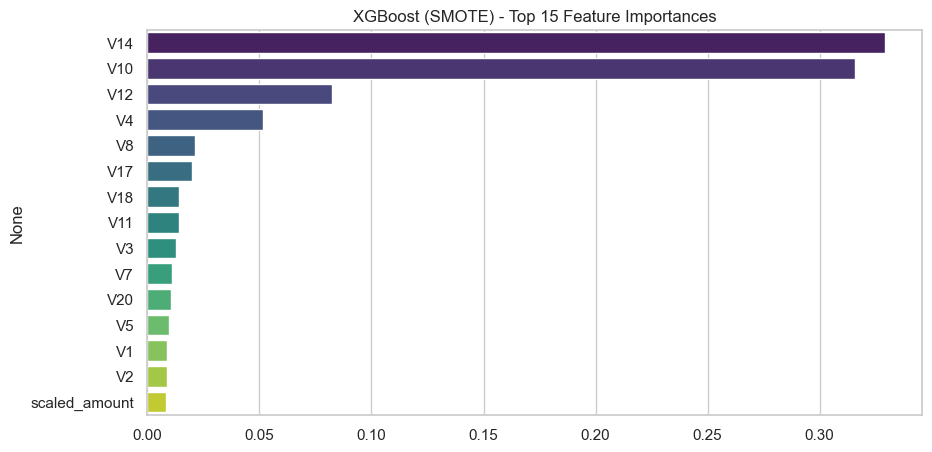

In [123]:
# Feature importance
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(10,5))
sns.barplot(x=importances[indices], y=X_train.columns[indices], palette="viridis")
plt.title("XGBoost (SMOTE) - Top 15 Feature Importances")
plt.show()

### 🔍 Observation
- XGBoost usually achieves the **best ROC AUC** and recall.  
- Hyperparameter tuning improves generalization.  
- Important features often align with Random Forest results.


## Step 5: Model Comparisom
 - Compare all models (ROC AUC).


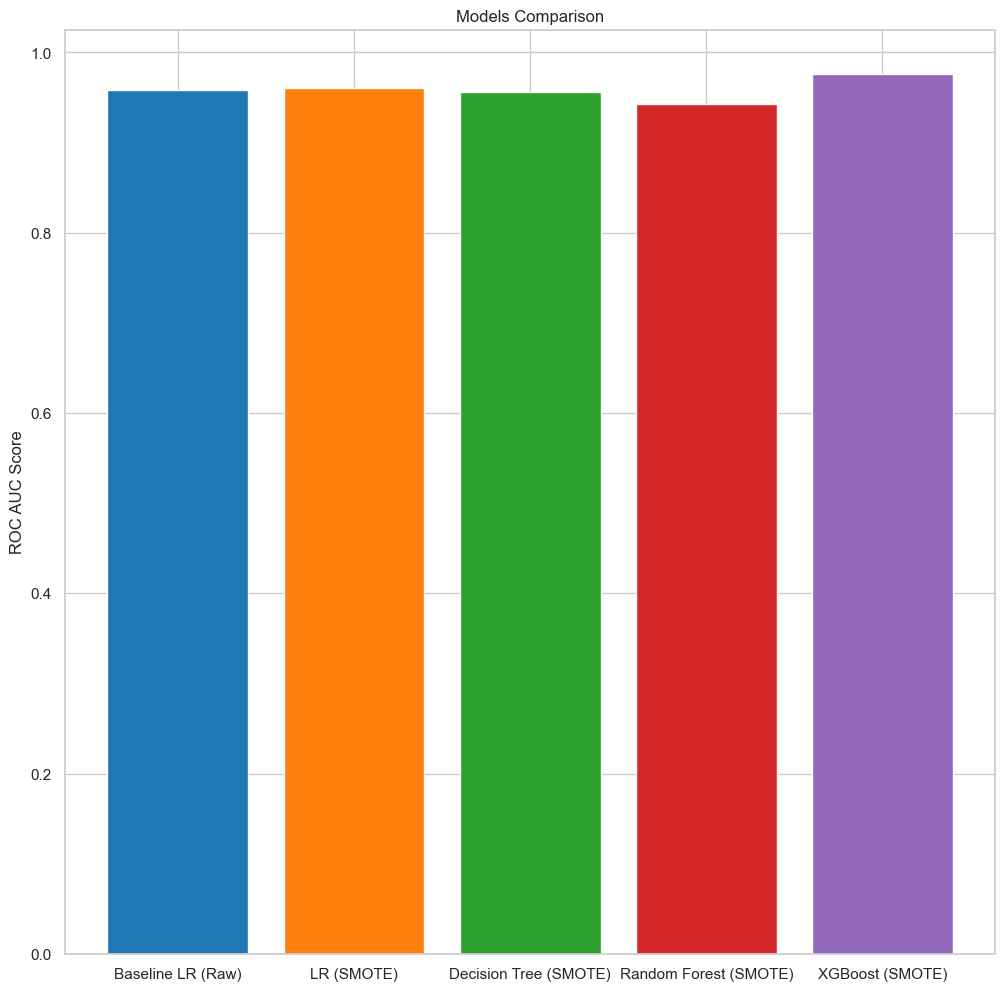

{'Baseline LR (Raw)': 0.9588769278936871,
 'LR (SMOTE)': 0.9602031459471613,
 'Decision Tree (SMOTE)': 0.9562079547069824,
 'Random Forest (SMOTE)': 0.9431912290301931,
 'XGBoost (SMOTE)': 0.976355599241524}

In [124]:
roc_scores = {
    "Baseline LR (Raw)": roc_auc_score(y_test, y_proba),
    "LR (SMOTE)": roc_auc_score(y_test, y_proba_lr_smote),
    "Decision Tree (SMOTE)": roc_auc_score(y_test, y_proba_dt_smote),
    "Random Forest (SMOTE)": roc_auc_score(y_test, y_proba_rf_smote),
    "XGBoost (SMOTE)": roc_auc_score(y_test, y_proba_xgb_smote)
}
plt.figure(figsize=(12,12))
plt.bar(roc_scores.keys(), roc_scores.values(), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
plt.ylabel("ROC AUC Score")
plt.title("Models Comparison")
plt.show()

roc_scores


### Save models

In [125]:
# Persist model for deployment (example uses joblib)
os.makedirs("../models", exist_ok=True)

joblib.dump(lr, "../models/logistic_regression_baseline_model.joblib")
print("Saved Logistic Regression baseline model to ../models/")
joblib.dump(lr_smote, "../models/logistic_regression_smote_model.joblib")
print("Saved Logistic Regression model(SMOTE) to ../models/")
joblib.dump(dt_smote, "../models/decision_tree_smote_model.joblib")
print("Saved Decision Tree model(SMOTE) to ../models/")
joblib.dump(rf_smote, "../models/random_forest_smote_model.joblib")
print("Saved Random Forest model(SMOTE) to ../models/")
joblib.dump(best_xgb, "../models/xgboost_smote_model.joblib")
print("Saved XGBoost model(SMOTE) to ../models/")

Saved Logistic Regression baseline model to ../models/
Saved Logistic Regression model(SMOTE) to ../models/
Saved Decision Tree model(SMOTE) to ../models/
Saved Random Forest model(SMOTE) to ../models/
Saved XGBoost model(SMOTE) to ../models/


## 🔍 Model Comparison: Random Forest (SMOTE) vs XGBoost (SMOTE)

### Random Forest (SMOTE)
- **Confusion Matrix:**  
  - True Negatives: 56,644  
  - False Positives: 7  
  - False Negatives: 22  
  - True Positives: 73  
- **Precision (Fraud):** 0.91  
- **Recall (Fraud):** 0.77  
- **F1-score (Fraud):** 0.83  
- **ROC AUC:** 0.9432  
- **PR-AUC:** 0.8102  

### XGBoost (SMOTE)
- **Confusion Matrix:**  
  - True Negatives: 56,636  
  - False Positives: 15  
  - False Negatives: 20  
  - True Positives: 75  
- **Precision (Fraud):** 0.83  
- **Recall (Fraud):** 0.79  
- **F1-score (Fraud):** 0.81  
- **ROC AUC:** 0.9764  
- **PR-AUC:** 0.8197  

---

### **Interpretation**

- **Recall (Fraud):**  
  XGBoost (0.79) detects slightly more frauds than Random Forest (0.77).

- **Precision (Fraud):**  
  Random Forest (0.91) is higher, meaning fewer false alarms than XGBoost (0.83).

- **F1-score (Fraud):**  
  Random Forest (0.83) is a bit higher, showing a better balance between precision and recall.

- **ROC AUC & PR-AUC:**  
  XGBoost has higher ROC AUC (0.9764 vs 0.9432) and PR-AUC (0.8197 vs 0.8102), indicating better overall ranking and performance for the minority class.

---

### **Summary**

- **Random Forest (SMOTE):**  
  Fewer false positives, higher precision, slightly lower recall.  
  Best if you want to minimize false alarms.

- **XGBoost (SMOTE):**  
  Slightly better at catching frauds (higher recall), higher ROC AUC and PR-AUC, but with more false positives (lower precision).  
  Best if you want to maximize fraud detection, even at the cost of more false alarms.

**Overall:**  
Both models performed very well. If our priority is to catch as many frauds as possible, XGBoost (SMOTE) is preferred. If we want fewer false positives, Random Forest (SMOTE) is slightly better. For most fraud detection tasks, XGBoost’s higher recall and AUC scores make it the top choice.

## 🔍 Final Observations
- **Logistic Regression**: Good baseline; improved with SMOTE.
- **Decision Tree**: Simple but prone to overfitting; decent recall.  
- **Random Forest**: Balanced performance; interpretable via feature importance.  
- **XGBoost**: Best performer in most fraud detection scenarios; strong precision-recall tradeoff. 

## 📝 Overall Summary

- **Logistic Regression** serves as a strong baseline and shows improvement with SMOTE, but struggles to capture complex fraud patterns and typically has lower recall for the minority class.
- **Decision Tree** is simple and interpretable, with improved recall after SMOTE, but is prone to overfitting and may not generalize as well as ensemble methods.
- **Random Forest** offers balanced performance, reducing overfitting compared to a single tree, and provides useful feature importance insights. It achieves high precision and a good trade-off between recall and false positives.
- **XGBoost** consistently delivers the best results in terms of ROC AUC, PR-AUC, and recall, making it the top performer for fraud detection in this scenario. It is especially effective at identifying rare fraud cases, though it may produce more false positives than Random Forest.

**Conclusion:**  
For credit card fraud detection, tree-based ensemble models (Random Forest and XGBoost) outperform simpler models, especially when combined with SMOTE to address class imbalance. XGBoost is generally the best choice when maximizing fraud detection is the priority, while Random Forest is preferred if minimizing false alarms is more important. Always evaluate models using recall, precision, PR-AUC, and ROC AUC to ensure robust performance on imbalanced data.